In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cpu


# Initialize for CPU & GPU

In [2]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.1/504.1 kB 10.9 MB/s eta 0:00:0000:01
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00a 0:00:01
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.3/732.3 kB 11.5 MB/s eta 0:00:00a 0:00:01
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-2b6v96id
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-2b6v96id
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 20362ee7c368387cf6b557f7ed775f72220329a0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-n

# Import

In [4]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU, LeakyReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch import autograd
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import to_dense_adj

from sklearn.model_selection import train_test_split

# DataLoader

In [28]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attr = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
        path: str,
    ):
        
        self.raw_edge_flag = torch.LongTensor(edge_flag[:-1])
        self.raw_edge_index = torch.LongTensor(edge_index).T
        self.raw_edge_attr = edge_attr
        self.raw_node_attr = node_attr 
        self.node_flag = torch.LongTensor(node_flag[:-1])
        self.node_index = torch.LongTensor(node_index)
        
        self.ts_list = ts_list
        
        self.path = path
        
        self.node_attr = None
        self.edge_flag = None
        self.edge_index = None
        
        self._set_snapshot_count()
        self._set_node_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.ts_list)
    
    def _set_node_count(self):
        self.node_count = self.raw_node_attr.shape[0]
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_edge_attr))
        
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_node_attr))
        
    def extend_node_attr(self):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        node_index = self.node_index
        node_attr = self.node_attr_encoded.index_select(dim=0,index=self.node_index)
        node_flag = self.node_flag
        
        edge_index = self.raw_edge_index
        edge_attr = self.edge_attr_encoded
        edge_flag = self.raw_edge_flag
        
        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)

        base = 0
        new_node_attr = []
        new_edge_flag = []
        new_edge_index = []
        
        for i_snapshot in range(self.snapshot_count):
            _node_index = node_index_split[i_snapshot]
            _node_attr = node_attr_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            if _edge_index.shape[1] != _edge_attr.shape[0]:
                print(i_snapshot, edge_index.shape, _edge_attr.shape)
                raise
            if _edge_index.shape[1] > 0:
                index_dict = {}
                for i_edge in range(_edge_index.shape[1]):
                    index_tuple = tuple(_edge_index[:,i_edge].tolist())
                    if index_tuple in index_dict:
                        index_dict[index_tuple] += [i_edge]
                    else:
                        index_dict[index_tuple] = [i_edge]

                _new_edge_index = []
                _new_edge_attr = []
                for key in index_dict.keys():
                    _new_edge_index.append(key)
                    _new_edge_attr.append(torch.sum(_edge_attr.index_select(0, torch.LongTensor(index_dict[key])),dim=0).unsqueeze(0))

                _new_edge_index = torch.LongTensor(_new_edge_index).T
                _new_edge_attr = torch.cat(_new_edge_attr,dim=0)
                
                base += _new_edge_index.shape[1]
                new_edge_index.append(_new_edge_index)

#                 _source_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _target_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _source_attr.index_add_(0, _new_edge_index[0], _new_edge_attr)
#                 _target_attr.index_add_(0, _new_edge_index[1], _new_edge_attr)
#                 new_node_attr.append(torch.cat([_node_attr,_source_attr,_target_attr], dim=1))

                _node_attr_extend = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1]))
                _node_attr_extend.index_add_(0, _new_edge_index[0], _new_edge_attr)
                _node_attr_extend.index_add_(0, _new_edge_index[1], _new_edge_attr)
                new_node_attr.append(torch.cat([_node_attr,_node_attr_extend], dim=1)) 
                
            new_edge_flag.append(base)
        
        self.node_attr = torch.cat(new_node_attr, dim=0).to(device)
        self.edge_flag = torch.LongTensor(new_edge_flag)
        self.edge_index = torch.cat(new_edge_index,dim=1).to(device)
    
    def remove_init_stop(self, threshold, period):
        node_index = self.node_index
        node_attr = self.node_attr
        node_flag = self.node_flag

        edge_index = self.edge_index
        edge_flag = self.edge_flag

        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)

        i_init = None
        i_stop = None
        for i_snapshot, node_num in enumerate(torch.diff(self.node_flag)):
            if node_num > threshold:
                i_init = i_snapshot+1
                break

        for i_snapshot, node_num in enumerate(torch.flip(torch.diff(self.node_flag),dims=[0])):
            if node_num > threshold:
                i_stop = self.node_flag.shape[0]-1-i_snapshot
                break
        
        new_node_attr = torch.cat(node_attr_split[i_init+1+period:i_stop-period],dim=0)
        new_node_index = torch.cat(node_index_split[i_init+1+period:i_stop-period],dim=0)
        new_edge_index = torch.cat(edge_index_split[i_init+1+period:i_stop-period],dim=1)

        new_node_flag = node_flag[i_init+period+1:i_stop-period-1]-node_flag[i_init+period]
        new_edge_flag = edge_flag[i_init+period+1:i_stop-period-1]-edge_flag[i_init+period]
        
        self.node_attr = new_node_attr
        self.node_index = new_node_index
        self.edge_index = new_edge_index
        
        self.node_flag = new_node_flag
        self.edge_flag = new_edge_flag
        self.ts_list = self.ts_list[i_init+1+period:i_stop-period]
        
        self._set_snapshot_count()
    
    def to(self,device):
        self.node_attr = self.node_attr.to(device)
        self.node_index = self.node_index.to(device)
        self.edge_index = self.edge_index.to(device)
    
    def get_adj_list(self):
        edge_index = self.edge_index
        edge_flag = self.edge_flag
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
        return adj_list

    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp=_timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp'],
            path = self.input_path
        )
        return dataset

In [29]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
annotation = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        continue

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    annotation.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, annotation_train, annotation_test = train_test_split(signals, annotation, test_size=0.2, random_state=1)
signals_train, signals_val, annotation_train, annotation_val = train_test_split(signals_train, annotation_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [30]:
_interval = 60
_overlap = 30

node_num_list = []
for signal in signals_train:
    node_num_list += torch.diff(signal.node_flag).tolist()
    
threshold = np.median(node_num_list)
period = 3

print(f"Threshold = {threshold} Period = {period}")

node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.raw_node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.raw_edge_attr for sample in signals_train]))

for i_signal, signal in enumerate(signals_train):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)
    
y_train = []
for self, annotation in zip(signals_train, annotation_train): 
    ts_list = self.ts_list
    y = torch.zeros(self.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_train.append(y)


    
for i_signal, signal in enumerate(signals_val):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)

y_val = []
for signal, annotation in zip(signals_val, annotation_val): 
    ts_list = signal.ts_list
    y = torch.zeros(signal.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_val.append(y)

for signal in signals_train:
    signal.to(device)

for signal in signals_val:
    signal.to(device)
    
    
IN_CHANNELS = signals_train[0].node_attr.shape[1]
# EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

Threshold = 77.0 Period = 3


In [17]:
signal = signals_train[0]

node_index = signal.node_index
node_attr = signal.node_attr
node_flag = signal.node_flag

edge_index = signal.edge_index
edge_flag = signal.edge_flag

node_index_split = torch.tensor_split(node_index, node_flag)
node_attr_split = torch.tensor_split(node_attr, node_flag)
edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)

# Model

In [8]:
class MultiGraphConv(torch.nn.Module):
    def __init__(
        self, 
        channels, 
    ):
        super().__init__()
         
        self.convs = nn.ModuleList()
        
        net1 = Seq(
            Lin(channels, channels),
            LeakyReLU(),
            Lin(channels, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels*2),
            LeakyReLU(),
        )
        conv1 = GINConv(net1,train_eps=True)
        self.convs.append(conv1)
        
        net2 = Seq(
            Lin(channels*2, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels),
            LeakyReLU(),
            Lin(channels, channels),
            LeakyReLU(),
        )
        conv2 = GINConv(net2,train_eps=True)
        self.convs.append(conv2)
        

    def forward(self, x, edge_index):
        out = x
        for conv in self.convs:
            out = conv(x=out, edge_index=edge_index)
        return out

In [9]:
class GraphGRU(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()

        self.channels = channels
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiGraphConv(channels = self.channels)

        self.conv_h_z = MultiGraphConv(channels = self.channels)
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiGraphConv(channels = self.channels)

        self.conv_h_r = MultiGraphConv(channels = self.channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiGraphConv(channels = self.channels)

        self.conv_h_h = MultiGraphConv(channels = self.channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, H):
        Z = self.conv_x_z(X, edge_index)
        Z = Z + self.conv_h_z(H, edge_index)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, H):
        R = self.conv_x_r(X, edge_index)
        R = R + self.conv_h_r(H, edge_index)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, H, R):
        H_tilde = self.conv_x_h(X, edge_index)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, H)
        R = self._calculate_reset_gate(X, edge_index, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

In [10]:
def create_hidden(num_node, out_channels):
#     hidden_global = torch.FloatTensor(np.zeros([num_node,out_channels])).to(device)
    hidden =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    return hidden

def select_hidden(hidden, index):
#     h = hidden_global[index] #REGULAR INDEXING
    h = hidden.index_select(dim=0, index=index) #INDEX SELECT
    return h

def update_hidden(num_node, out_channels, h, index):
    # hidden_global[index] = h.detach() #REGULAR INDEXING
    # for key,value in mapping.items():
    #     hidden_global[value] = h[key] 
    hidden = torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    hidden.index_add_(0, index, h)  
    return hidden

# def update_hidden(hidden, h, index):
#     hidden.index_copy_(0, index, h)  
#     return hidden

class GraphGRULayer(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()
        self.gru = GraphGRU(
            channels = channels,
            bias = bias
        )
        
        self.channels = channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_flag: torch.LongTensor,
        num_node: int,
        direction: bool # True for Forward; False for Backward
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
        hidden = create_hidden(num_node, self.channels)
        
        outs = []
        if direction:
            snapshot_index = range(len(X_split))
        else:
            snapshot_index = range(len(X_split)-1,-1,-1)
        for i_snapshot in snapshot_index:
            _X = X_split[i_snapshot]
            _node_index = node_index_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]

            _hidden = select_hidden(hidden, _node_index)
            _new_hidden = self.gru(_X, _edge_index, _hidden)
            hidden = update_hidden(num_node, self.channels, _new_hidden, _node_index)
#             hidden = update_hidden(hidden, _new_hidden, _node_index)
            outs.append(_new_hidden)
        if direction:
            H = torch.cat(outs)
        else:
            H = torch.cat(outs[::-1])
        return H

In [11]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        embed_layers,  
        decide_layers,
    ):
        super(TGAE, self).__init__()
        
        # Encoder Embeding
#         layers = [torch.nn.BatchNorm1d(in_channels)]
        layers = []
        pre_h_num = in_channels
        for h_num in embed_layers[:-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.embed_net = Seq(*layers)
                
        self.encoder_gru = GraphGRULayer(channels=embed_layers[-1])

        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in decide_layers:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
#         layers.append(torch.nn.Sigmoid())
        self.decide_net = Seq(*layers)
        
        # Decoder
#         self.decoder = InnerProductDecoder()
        layers = []
        pre_h_num = out_channels
        for h_num in decide_layers[::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.decode_decide_net = Seq(*layers)
        
        self.decoder_gru = GraphGRULayer(channels=embed_layers[-1])
        
        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in embed_layers[:-1][::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,in_channels))
        self.decode_embed_net = Seq(*layers)
        

    def forward(self, x, node_index, node_flag, edge_index, edge_flag, num_node):
        # Encoder
        out = self.embed_net(x)
        
        # GNN layer
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, edge_flag, num_node, True) 
        
        out = self.decide_net(h_encoder)
        out = self.decode_decide_net(out)
 
        h_decoder = self.decoder_gru(out, node_index, node_flag, torch.flip(edge_index,dims=(0,)), edge_flag, num_node, True)
        
        out = self.decode_embed_net(h_decoder)

        return out
    

# Training

In [12]:
model = torch.load(
    "/kaggle/input/tgae-model-saved/TGAE2_GRUConv_100_5.7457_6.0806.model",
    map_location=torch.device(device)
)

In [13]:
# model = TGAE(
#     in_channels=IN_CHANNELS, 
#     out_channels=32, 
#     embed_layers=[128,256,512,256],
#     decide_layers=[512,256,128],
# )

# loss_f = torch.nn.CrossEntropyLoss()
loss_f = torch.nn.MSELoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (embed_net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=63, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_gru): GraphGRULayer(
    (gru): GraphGRU(
      (conv_x_z): MultiGraphConv(
        (convs): ModuleList(
          (0): GINConv(nn=Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=256, out_features=512, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=512, out_features=512, bias=True)
            (5): Le

## Train Loop

In [14]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device):
    model.train()
    
    X = signal.node_attr
    node_index = signal.node_index
    node_flag = signal.node_flag
    edge_index = signal.edge_index
    edge_flag = signal.edge_flag
    
    outs = model(X, node_index, node_flag, edge_index, edge_flag, signal.raw_node_attr.shape[0])

    train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
    total_loss = torch.mean(train_losses)
    snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return snapshot_losses

## Test Loop

In [15]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device):
    with torch.no_grad():
        X = signal.node_attr
        node_index = signal.node_index
        node_flag = signal.node_flag
        edge_index = signal.edge_index
        edge_flag = signal.edge_flag

        outs = model(X, node_index, node_flag, edge_index, edge_flag, signal.raw_node_attr.shape[0])

        train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
        total_loss = torch.mean(train_losses)
        snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    return snapshot_losses

In [16]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for signal in signals_train:
            snapshot_losses = train_loop(signal, model, loss_f, optimizer, device)
#             print(np.mean(train_loss))
            train_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            
        
        if i_epoch % 5 == 0:
            val_losses = []
            for signal in signals_val:
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
                val_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f} val loss {np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
#             if i_epoch % 10 == 0:
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [46]:
history_train_list = []
history_val_list = []

1/50: cost 18.1047s train loss 16.9904
2/50: cost 18.8477s train loss 15.6121
3/50: cost 18.4572s train loss 15.2068
4/50: cost 18.6338s train loss 13.5396
5/50: cost 20.8074s train loss 12.8090 val loss 12.4005
6/50: cost 18.4755s train loss 11.6749
7/50: cost 17.7495s train loss 11.2192
8/50: cost 18.2669s train loss 11.0162
9/50: cost 17.7443s train loss 10.6508
10/50: cost 21.2325s train loss 10.1675 val loss 10.1351
11/50: cost 17.9592s train loss 9.8085
12/50: cost 18.1863s train loss 9.2389
13/50: cost 18.3696s train loss 8.5568
14/50: cost 17.8397s train loss 8.2732
15/50: cost 21.1005s train loss 8.0289 val loss 7.7143
16/50: cost 17.7613s train loss 8.0565
17/50: cost 18.4073s train loss 7.8849
18/50: cost 18.4799s train loss 7.8812
19/50: cost 17.8095s train loss 7.7522
20/50: cost 21.3751s train loss 7.9682 val loss 7.7819
21/50: cost 17.6257s train loss 7.5846
22/50: cost 18.3638s train loss 7.4881
23/50: cost 18.2828s train loss 7.2830
24/50: cost 17.7487s train loss 7.18

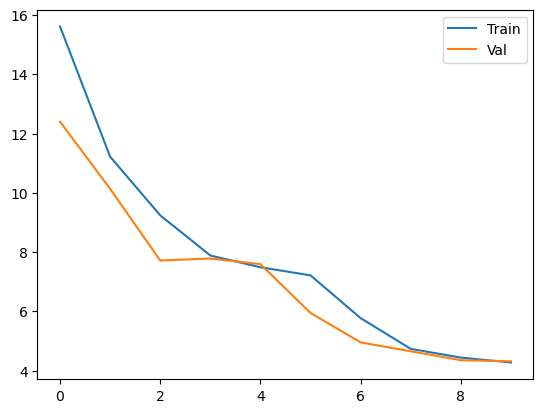

In [47]:
history_train, history_val = train_function(50)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

NameError: name 'history_train_list' is not defined

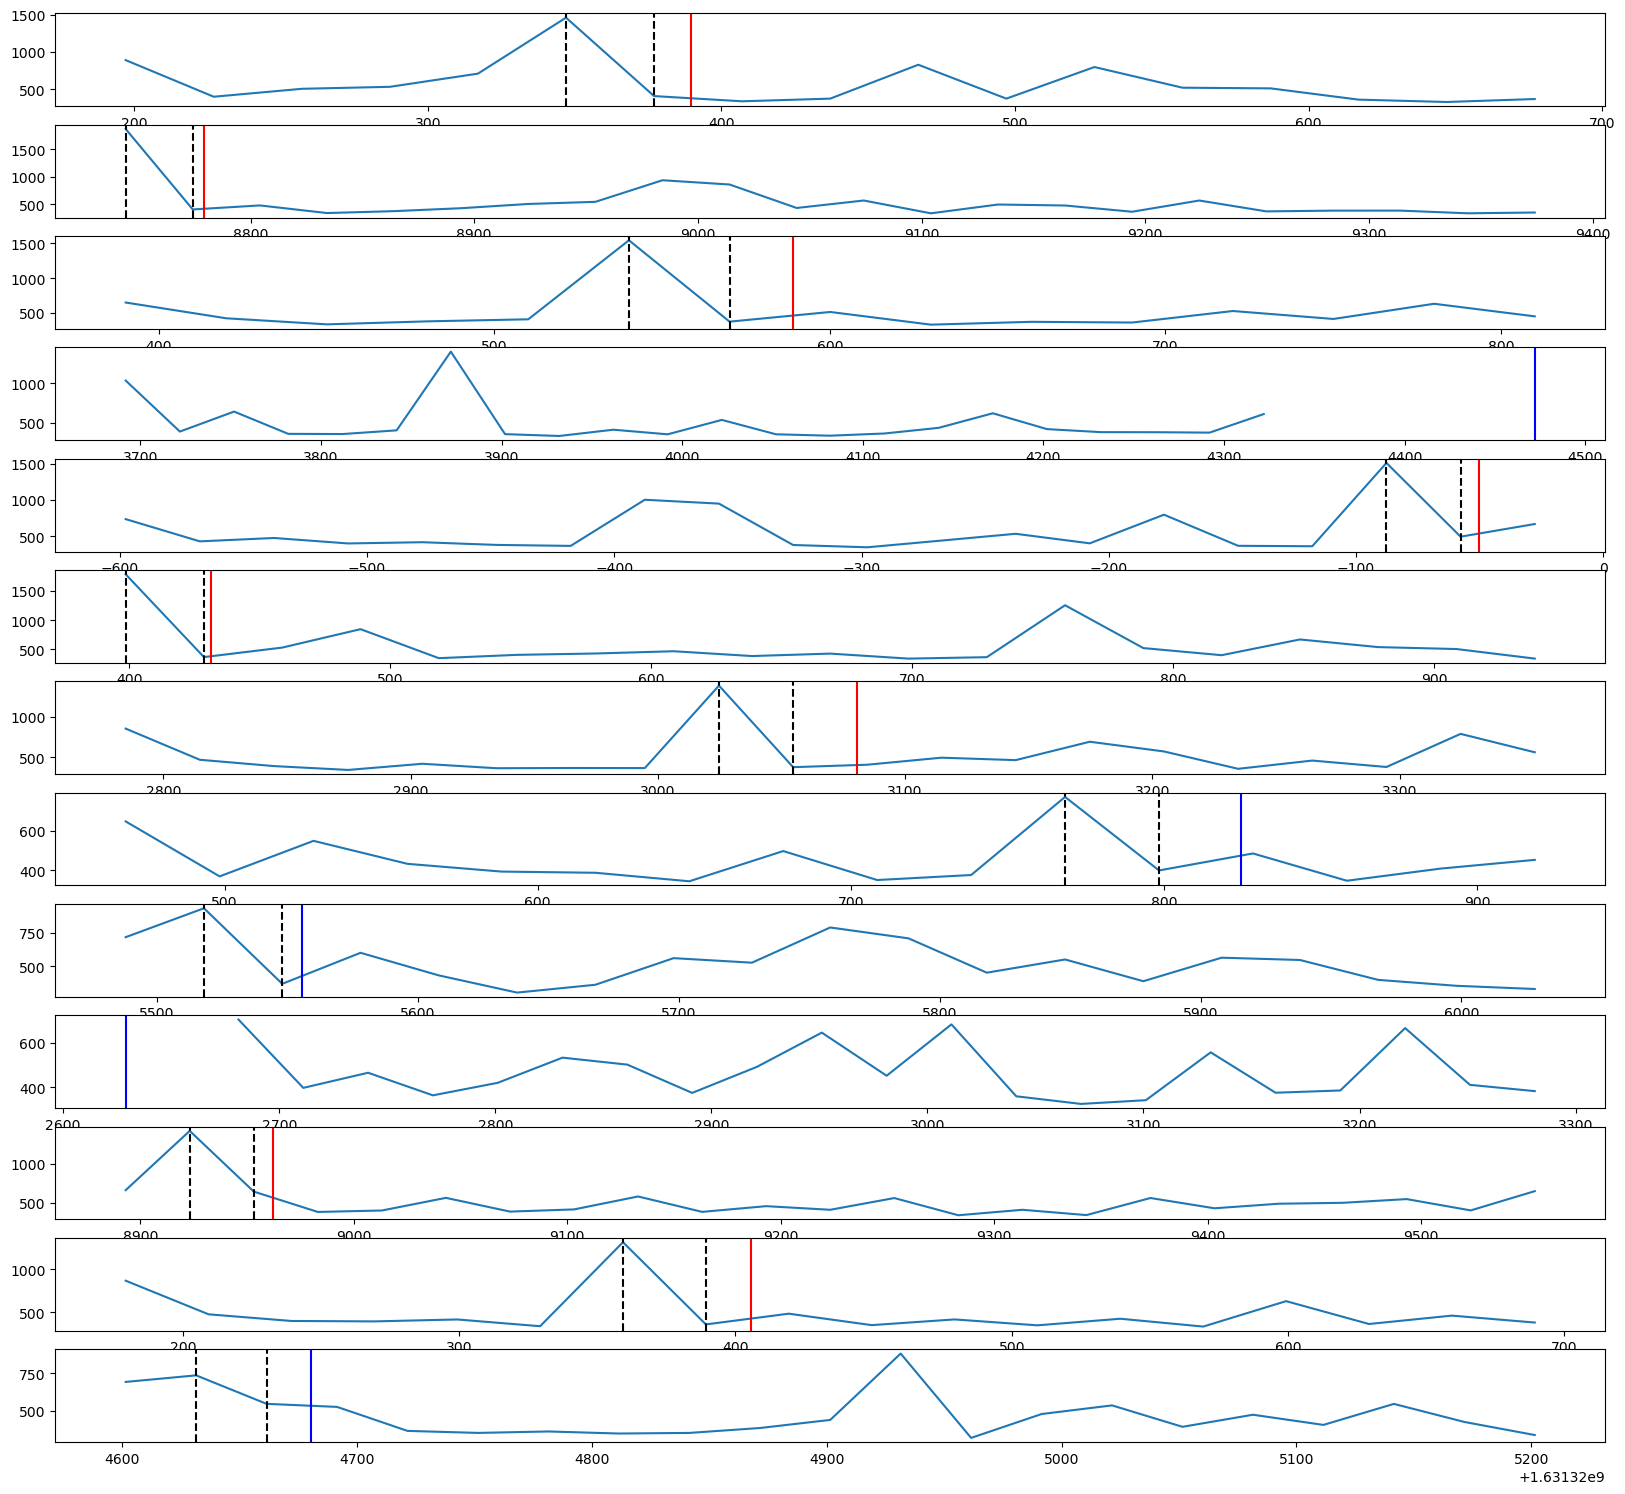

In [17]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, annotation, y) in enumerate(zip(signals_val, annotation_val, y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)

    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
    plt.plot(ts_list,[np.sum(loss) for loss in snapshot_losses])
    for ts, label in zip(ts_list, y):
        if label == 1:
            plt.axvline(x = ts, color = 'black', ls='--')
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])
# plt.show()
# plt.savefig(f'val_res_TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [50]:
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

51/100: cost 17.8753s train loss 4.2445
52/100: cost 17.9923s train loss 4.7625
53/100: cost 18.1662s train loss 4.4115
54/100: cost 17.9718s train loss 4.2255
55/100: cost 20.7264s train loss 4.5537 val loss 4.5924
56/100: cost 18.2545s train loss 4.6306
57/100: cost 17.6846s train loss 4.4737
58/100: cost 18.0123s train loss 4.2384
59/100: cost 17.8019s train loss 4.1533
60/100: cost 20.6472s train loss 4.1464 val loss 4.1833
61/100: cost 18.4327s train loss 4.0952
62/100: cost 17.7135s train loss 4.0713
63/100: cost 17.9417s train loss 4.0517
64/100: cost 17.9014s train loss 4.1499
65/100: cost 20.7771s train loss 4.1406 val loss 4.3333
66/100: cost 18.0238s train loss 4.1874
67/100: cost 19.6848s train loss 4.1083
68/100: cost 17.9914s train loss 4.0937
69/100: cost 17.8637s train loss 4.1384
70/100: cost 20.8066s train loss 3.9794 val loss 4.0724
71/100: cost 17.8264s train loss 3.9444
72/100: cost 18.0094s train loss 4.1399
73/100: cost 17.9657s train loss 3.9493
74/100: cost 18.

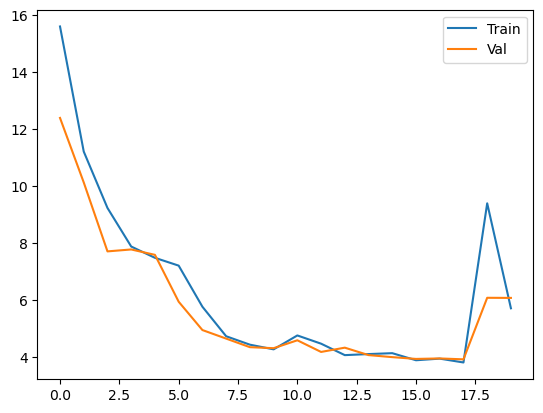

In [51]:
history_train, history_val = train_function(50)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

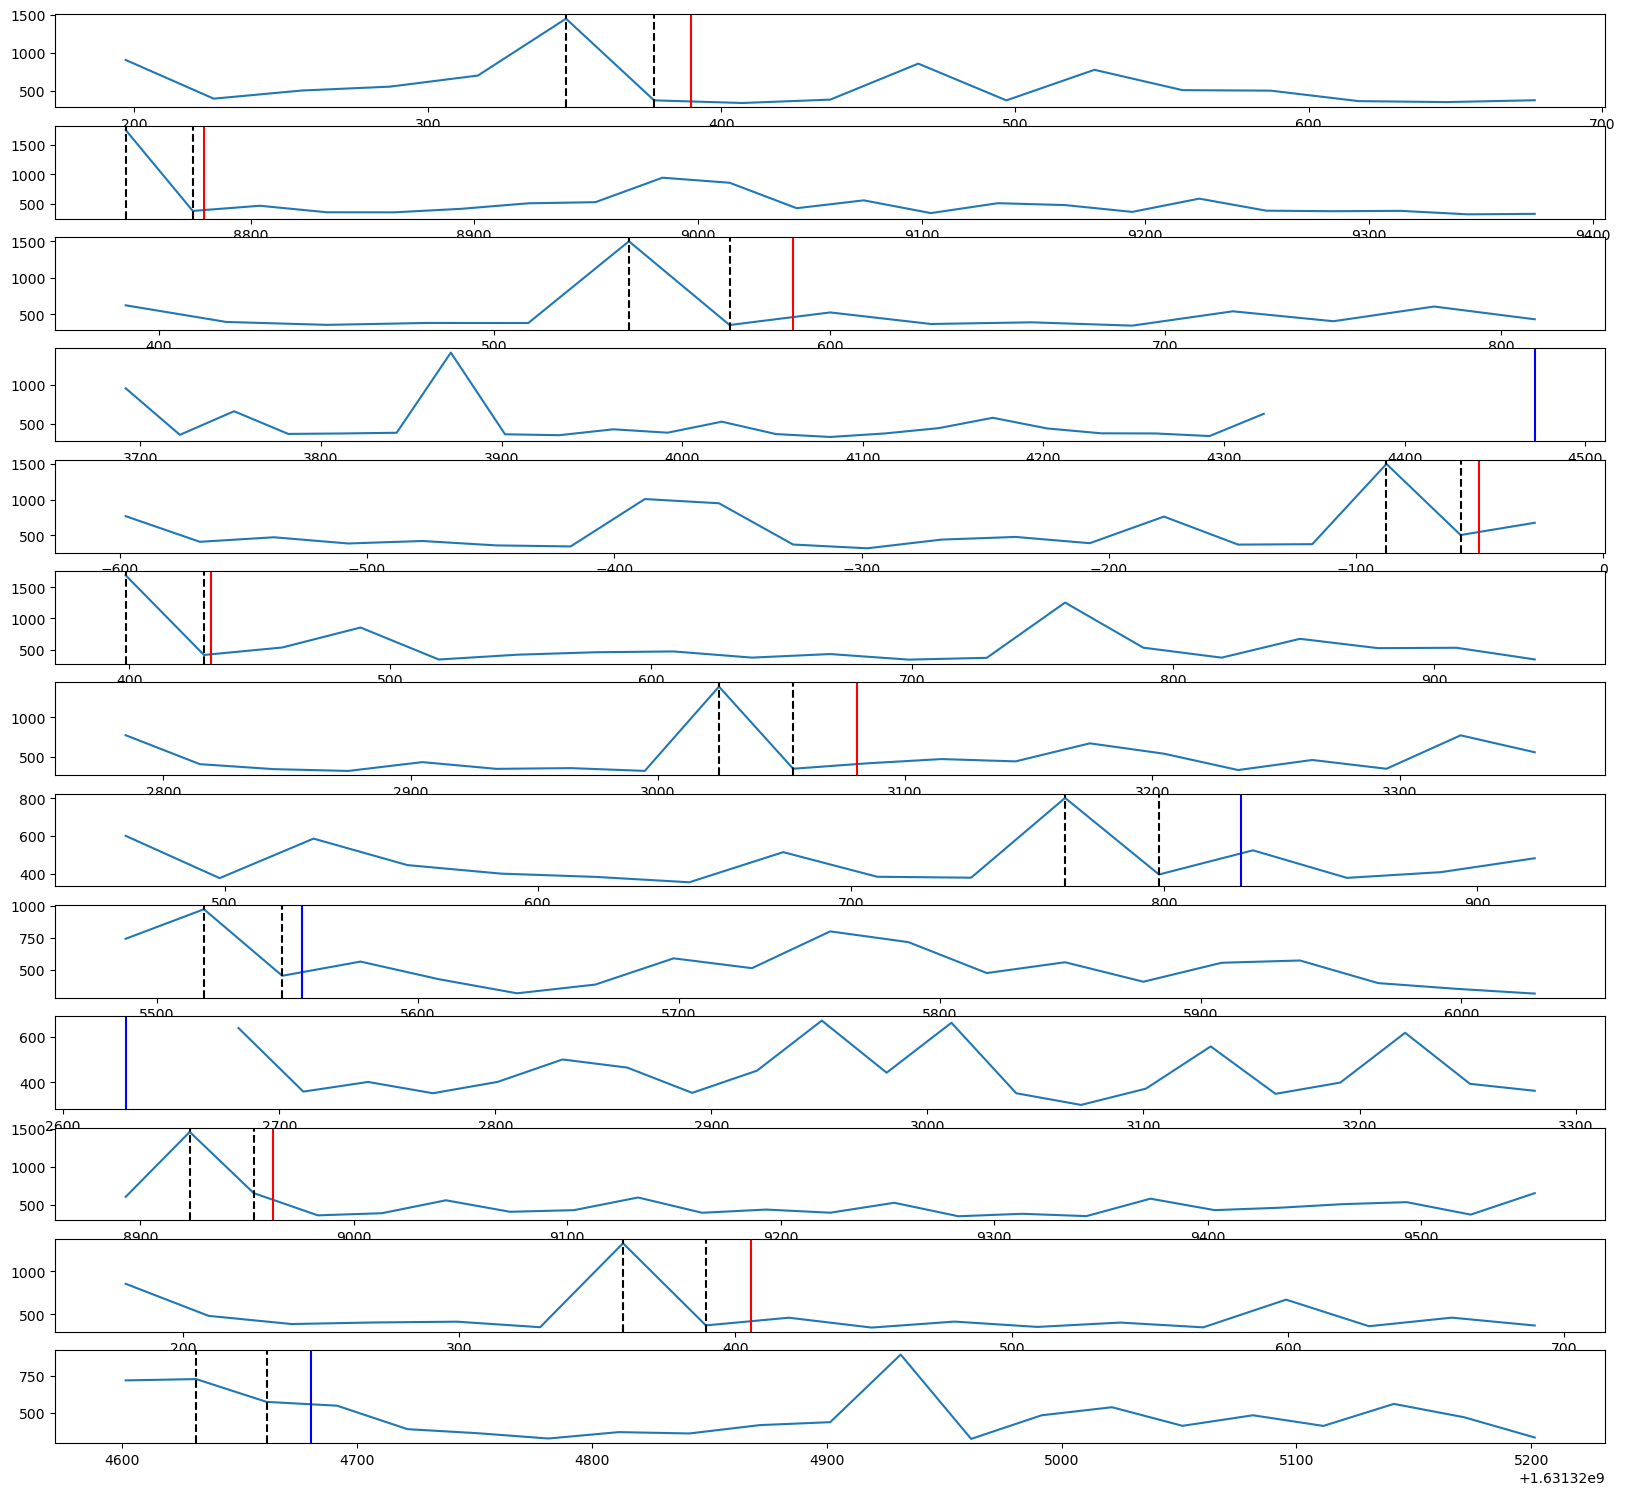

In [52]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, annotation, y) in enumerate(zip(signals_val, annotation_val, y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)

    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
    plt.plot(ts_list,[np.sum(loss) for loss in snapshot_losses])
    for ts, label in zip(ts_list, y):
        if label == 1:
            plt.axvline(x = ts, color = 'black', ls='--')
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])
# plt.show()
plt.savefig(f'val_res_TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [53]:
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

# Evaluation

In [32]:
snapshot_losses_list = []
for i_signal,(signal, y) in enumerate(zip(signals_val,y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
    snapshot_losses_list.append(snapshot_losses)

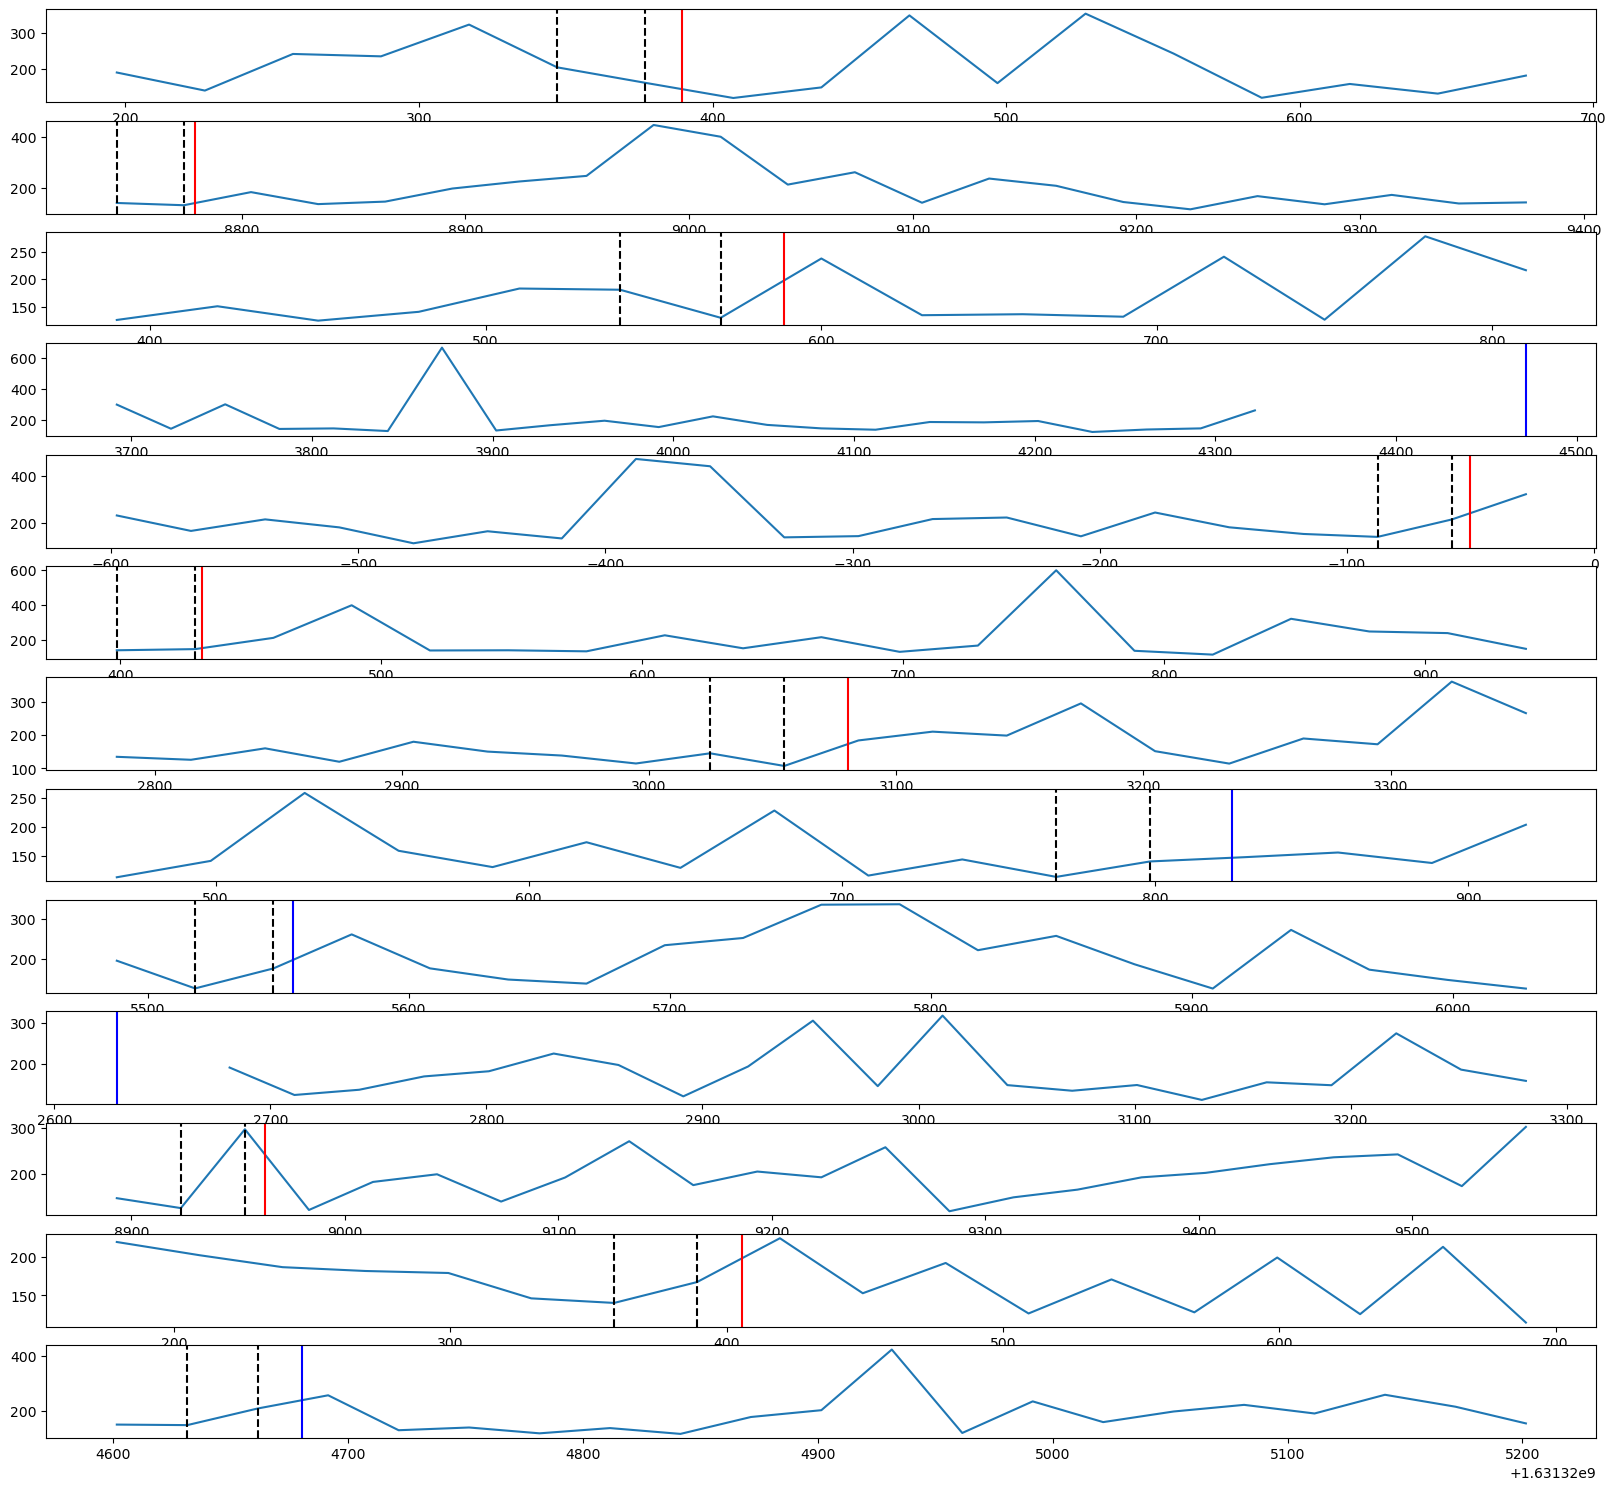

In [57]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, annotation, y) in enumerate(zip(signals_val, annotation_val, y_val)):
    snapshot_losses = snapshot_losses_list[i_signal]
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
    for ts, label in zip(ts_list, y):
        if label == 1:
            plt.axvline(x = ts, color = 'black', ls='--')
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])

[(0, 87, 0), (1, 76, 0), (2, 69, 0), (3, 92, 0), (4, 80, 0), (5, 199, 1), (6, 71, 1), (7, 74, 0), (8, 73, 0), (9, 92, 0), (10, 67, 0), (11, 81, 0), (12, 75, 0), (13, 114, 0), (14, 69, 0), (15, 81, 0), (16, 73, 0)]


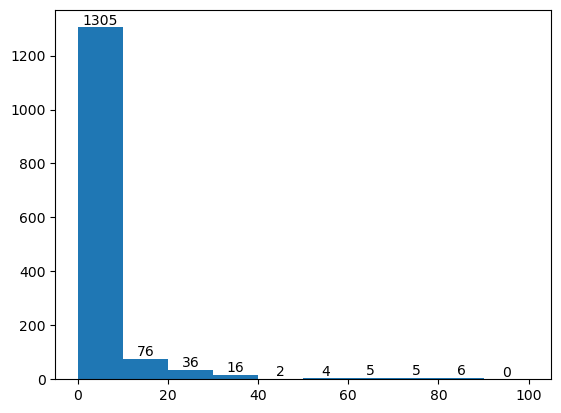

In [66]:
for signal, snapshot_losses, y in zip(signals_val, snapshot_losses_list,y_val):
#     print(snapshot_losses)
    print([(i_snapshot, len(loss),int(label)) for i_snapshot, (loss, label) in enumerate(zip(snapshot_losses, y))])
    loss_list = []
    for losses in snapshot_losses:
        loss_list += list(losses)
    counts, edges, bars = plt.hist(loss_list, range=(0,100), bins=10)
    plt.bar_label(bars)
    plt.show()
    break
    

In [67]:
import networkx as nx

def signal2graph(signal):

51: 135.2198486328125
46: 126.25457000732422
51: 160.8064727783203
44: 120.27857208251953
51: 180.69114685058594
45: 150.93157958984375
51: 139.0286865234375
10: 115.07916259765625
51: 145.77513122558594
44: 107.65326690673828
51: 184.6085662841797
44: 211.14031982421875
52: 199.23460388183594
50: 296.36358642578125
19: 152.20166015625
45: 114.71961212158203
59: 190.5116424560547
0: 173.01583862304688
52: 362.1629943847656
0: 266.93341064453125


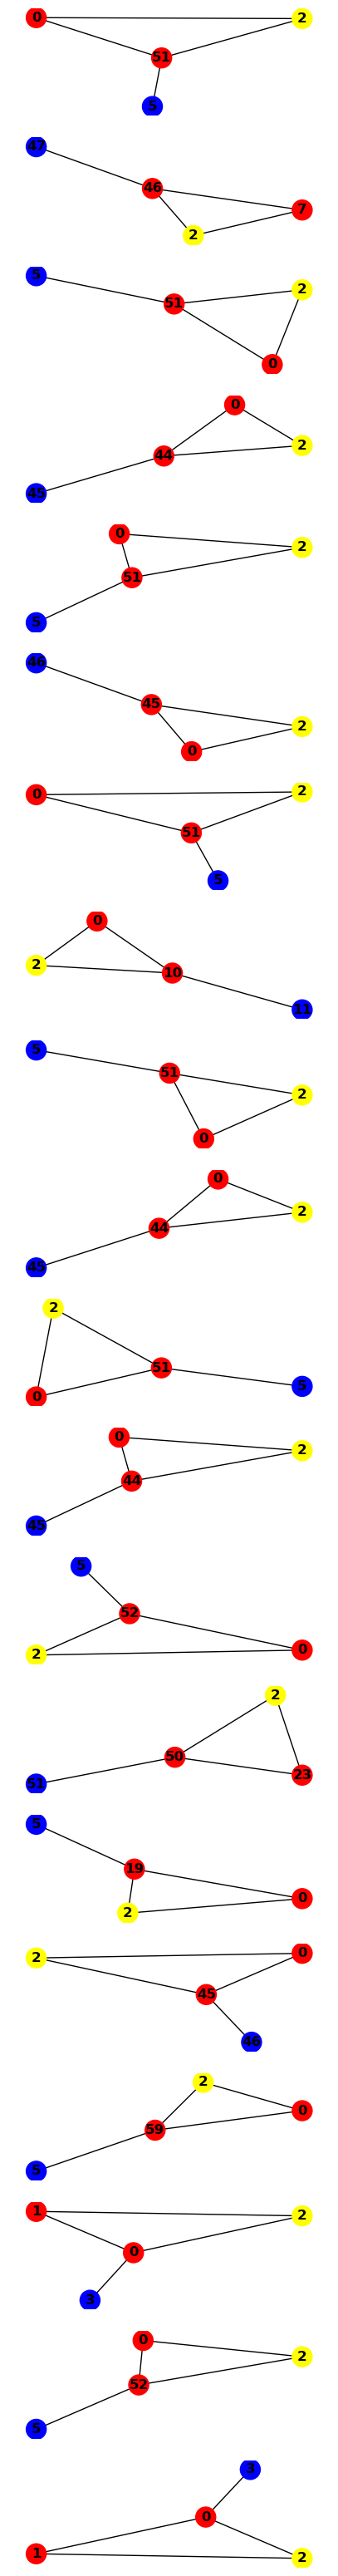

In [156]:
i_signal = 6
signal = signals_val[i_signal]
snapshot_losses = snapshot_losses_list[i_signal]

node_index = signal.node_index
node_attr = signal.node_attr
node_flag = signal.node_flag

edge_index = signal.edge_index
edge_flag = signal.edge_flag

raw_node_attr = signal.raw_node_attr

node_index_split = torch.tensor_split(signal.node_index, signal.node_flag)
node_attr_split = torch.tensor_split(signal.node_attr, signal.node_flag)
edge_index_split = torch.tensor_split(signal.edge_index, signal.edge_flag, dim=1)

node_type_split = np.split(raw_node_attr[node_index],node_flag)

color_map = {
    'Process':'red',
    'User':'yellow',
    'Executable':'blue',
    'Socket':'green',
    'File':'orange',
}

snapshot_list = []
plt.figure(figsize=(5,40))
for i_snapshot in range(signal.snapshot_count):
    
    i_node = np.argmax(snapshot_losses[i_snapshot])
    print(f"{i_node}: {snapshot_losses[i_snapshot][i_node]}")
    G = nx.Graph()
    _nodes = [(i_node, {'nodetype':nodetype[0]}) for i_node, nodetype in zip(list(range(node_index_split[i_snapshot].shape[0])), node_type_split[i_snapshot])]
    G.add_nodes_from(_nodes)
    G.add_edges_from(edge_index_split[i_snapshot].T.tolist())
    _subgraph = G.subgraph([i_node]+list(G.neighbors(i_node)))
    plt.subplot(signal.snapshot_count,1,i_snapshot+1)
    nx.draw(_subgraph, with_labels=True, font_weight='bold',node_color=[color_map[node[1]['nodetype']] for node in _subgraph.nodes(data=True)])
    

In [130]:
[color_map[node[1]['nodetype']] for node in _subgraph.nodes(data=True)]

['red', 'red', 'yellow', 'blue', 'red']

In [131]:
[node for node in _subgraph.nodes(data=True)]

[(0, {'nodetype': 'Process'}),
 (1, {'nodetype': 'Process'}),
 (2, {'nodetype': 'User'}),
 (3, {'nodetype': 'Executable'}),
 (4, {'nodetype': 'Process'})]

In [118]:

list(map(lambda x: color_map[x], list(node_type_split[0].flatten())))

['red',
 'red',
 'yellow',
 'blue',
 'red',
 'blue',
 'red',
 'red',
 'blue',
 'green',
 'green',
 'green',
 'red',
 'blue',
 'green',
 'green',
 'red',
 'blue',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',
 'red',
 'orange',
 'orange',
 'red',
 'blue',
 'orange',
 'orange',
 'orange',
 'orange',
 'red',
 'blue',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',
 'red',
 'orange',
 'red',
 'red',
 'blue',
 'orange',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'green',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'green',
 'orange',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red']

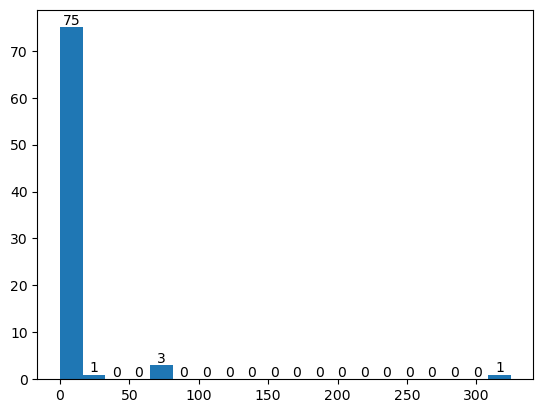

In [58]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][4],bins=20)
plt.bar_label(bars)
plt.show()

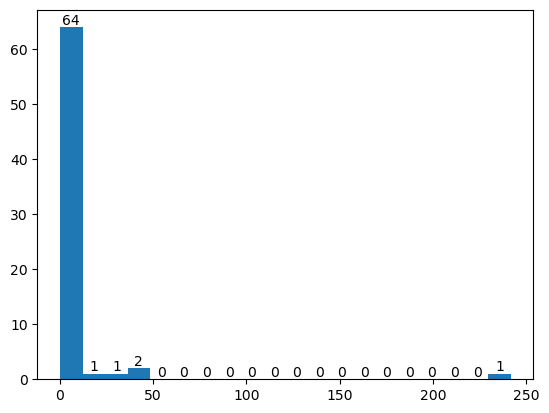

In [27]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][2],bins=20)
plt.bar_label(bars)
plt.show()

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [ ]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [ ]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()